In [1]:
#libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1(a)------------------------------------
# helper function with all the math for the numerator and denominator of the p_j|i matrix
def expDist(pt1, pt2, var):
    d = math.dist(pt1, pt2)
    e = -(d * d)
    f = e / (2 * var)
    result = math.exp(f)
    return(result)
# construct the p_j|i matrix
def jgiMat(df, vars = 1):
    n = len(df) # number of points total
    if vars == 1:
        vars = [1] * n
    result = np.empty((n, n))
    for i in range(n):
        xi = df.iat[i, 0]
        yi = df.iat[i, 1]
        pti = [xi, yi]
        r = []
        denominator = 0
        for j in range(n):
            # calculate the numerator of the equation
            xj = df.iat[j, 0]
            yj = df.iat[j, 1]
            ptj = [xj, yj]
            numerator = expDist(pti, ptj, vars[i])
            r.append(numerator)
            # calculate the denominator of the equation
            k = j
            if k != i: # ensure the sum only applies when k!=i
                ptk = ptj
                d = expDist(pti, ptk, vars[i])
                denominator += d
        row = [x / denominator for x in r]
        result[i] = row
    return(result)

In [3]:
df = (pd.read_table("problem1.tsv", sep="\t", header=None)
        .rename(columns = {'0':'x'})
        .rename(columns = {'1':'y'})
     )
df.columns = ["x", "y"]

pjgi = jgiMat(df)
for r in range(5):
    print(np.sum(pjgi[r,]))
print("...")

1.0207383872641373
1.020965204486741
1.0350869680614612
1.02094584469973
1.023984587833681
...


In [4]:
# 1(b)------------------------------------
#construct the p_ij matrix
#pjgi JUST THE TRANSPOSE
def pijMat(df, vars = 1):
    n = len(df)
    if vars == 1:
        vars = [1] * n
    pjgi = jgiMat(df, vars)
    pigj = pjgi.transpose()
    pij = (pjgi + pigj) / (2 * len(df))
    return(pij)

In [5]:
pij = pijMat(df)
print(np.sum(pij))

1.0403048156926824


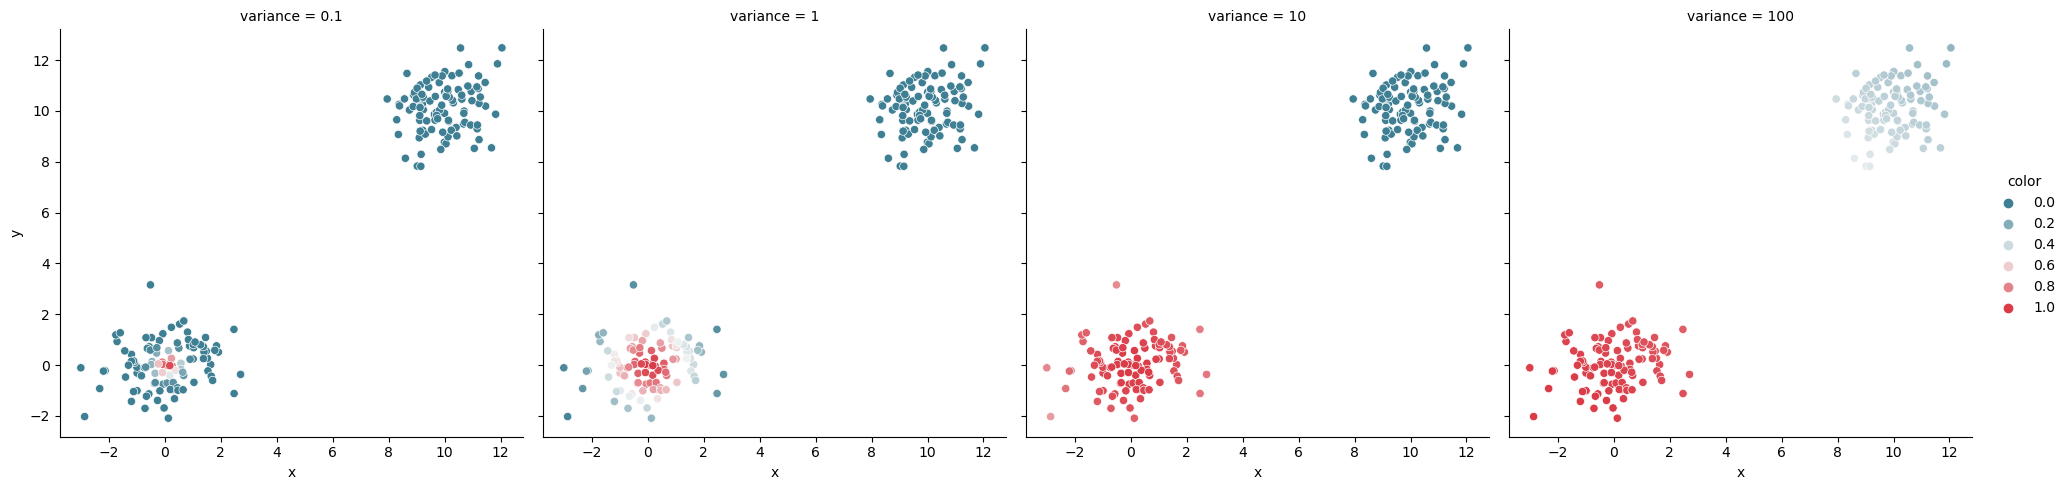

In [6]:
# 1(c)------------------------------------
ef = df.copy()
for v in [0.1, 1, 10, 100]:
    pij = pijMat(df, vars = [v] * len(df))
    wj = pij[0,] / max(pij[0,])
    ef[str(v)] = wj
ef = ef.melt(id_vars = ["x", "y"], var_name = "variance", value_name = "color")

cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.relplot(
    data = ef, x = "x", y = "y",
    hue = "color", palette = cmap,
    col = "variance"
)

In [7]:
# 1(d)------------------------------------
# helper function with all the math for the numerator and denominator of the qij matrix
def invDist(pt1, pt2):
    d = math.dist(pt1, pt2)
    e = 1 + (d * d)
    result = 1 / e
    return(result)
def qijMat(df):
    n = len(df) # number of points total
    mat = np.empty((n, n))
    denominator = 0
    for i in range(n):
        # relevant to numerator
        xi = df.iat[i, 0]
        yi = df.iat[i, 1]
        pti = [xi, yi]
        r = []
        # relevant to denominator
        k = i
        ptk = pti
        for j in range(n):
            # calculate the numerator of the equation
            xj = df.iat[j, 0]
            yj = df.iat[j, 1]
            ptj = [xj, yj]
            numerator = invDist(pti, ptj)
            r.append(numerator)
            # calculate the denominator of the equation
            l = j
            if l != k: # ensure the sum only applies when l!=k
                ptl = ptj
                d = invDist(ptk, ptl)
                denominator += d
        mat[i] = r
    result = mat / denominator # rather than normalizing by row, qij is normalized all at once
    return(result)

In [8]:
qij = qijMat(df)
print(np.sum(qij))

1.0290315391366034


Text(0, 0.5, 'y')

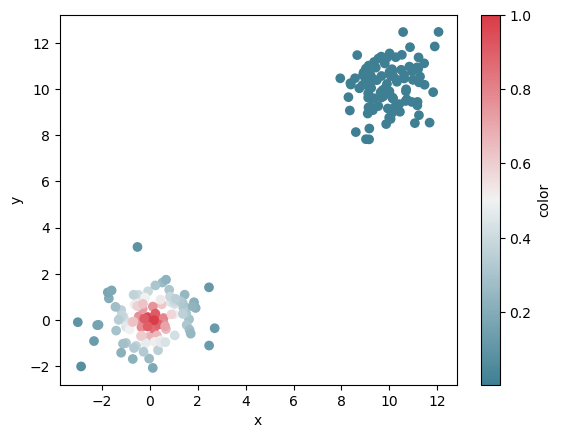

In [9]:
# 1(e)------------------------------------
ff = df.copy()
qij = qijMat(ff)
ff["color"] = qij[0,] / max(qij[0,])

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.scatter(
    data = ff, x = "x", y = "y",
    c = "color", cmap = cmap
)
plt.colorbar(label = "color")
plt.xlabel('x')
plt.ylabel('y')

In [10]:
# 1(f)------------------------------------
# helper function containing all the math for KLD
def logExpression(p, q):
    if p == 0: # avoids NaN when taking log(0)
        result = 0
    else:
        result = p * math.log(p / q)
    return(result)
# calculate KLD of P given Q
def KLD(P, Q, vars = 1):
    n = len(P)
    if vars == 1:
        vars = [1] * n
    pij = pijMat(P, vars)
    qij = qijMat(Q)
    outerSum = 0
    for i in range(n):
        innerSum = 0
        for j in range(n):
            if j != i: # ensures sum only applies when j!=i
                p = pij[i, j]
                q = qij[i, j]    
                innerSum += logExpression(p, q)
        outerSum += innerSum
    result = outerSum
    return(result)

In [11]:
# 1(g)------------------------------------
for v in [0.1, 1, 100]:
    result = KLD(df, df, [v] * len(df))
    print("When variance =", v, ", KL(P||Q) =", result)

When variance = 0.1 , KL(P||Q) = 1.2980311536488227
When variance = 1 , KL(P||Q) = 0.10541352321790873
When variance = 100 , KL(P||Q) = 0.7473665628685073


In [12]:
# 1(i)------------------------------------
gf = df.copy()
# move the second cluster away from the first cluster
gf.iloc[100:len(gf)] = gf.iloc[100:len(gf)] + 5
print("The KL-divergence for the new projection is", KLD(df, gf))

The KL-divergence for the new projection is 0.09707587807906544


Text(0, 0.5, 'y')

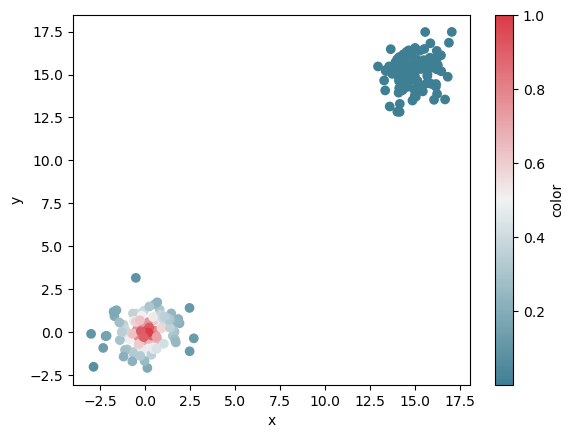

In [13]:
qij = qijMat(gf)
gf["color"] = qij[0,] / max(qij[0,])

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.scatter(
    data = gf, x = "x", y = "y",
    c = "color", cmap = cmap
)
plt.colorbar(label = "color")
plt.xlabel('x')
plt.ylabel('y')

In [14]:
# 1(j)------------------------------------
# helper function containing the p*log(p) operation from shannon entropy
def logExpression2(p):
    if(p == 0):
        result = 0
    else:
        # used log base 2 for entropy
        result = p * math.log2(p)
    return result
# calculate shannon entropy for a vector of probabilities
def H(Pi):
    n = len(Pi)
    result = 0
    for i in range(n):
        p = Pi[i]
        result += logExpression2(p)
    return(-result)
# calculate the perplexity for a vector of probabilities
def Perp(Pi):
    result = 2.0 ** H(Pi)
    return(result)
#return a single row from the p_j|i matrix
def jgiMatRow(df, i, var = 1):
    n = len(df)
    xi = df.iat[i, 0]
    yi = df.iat[i, 1]
    pti = [xi, yi]
    r = []
    denominator = 0
    for j in range(n):
        # calculate the numerator of the equation
        xj = df.iat[j, 0]
        yj = df.iat[j, 1]
        ptj = [xj, yj]
        numerator = expDist(pti, ptj, var)
        r.append(numerator)
        # calculate the denominator of the equation
        k = j
        if k != i: # ensure the sum only applies when k!=i
            ptk = ptj
            d = expDist(pti, ptk, var)
            denominator += d
    result = [x / denominator for x in r]
    return(result)
# return the variances that should be used for each i given a desired perplexity
def Vars(df, p, within = 0.5, startVar = 1):
    n = len(df)
    result = []
    for i in range(n):
        print(".", end = "")
        # start with the starting variance. 1 is the default since it works well with the way we change variance in the algo
        vari = startVar
        Pi = jgiMatRow(df, i, vari)
        diff = p - Perp(Pi)
        #while our perplexity is within "within" units of the desired perplexity, test a different variance
        # increasing "within" makes the algorithm converge earlier on and thus run faster
        while abs(diff) > within:
            Pi = jgiMatRow(df, i, vari)
            diff = p - Perp(Pi)
            #if our perplexity is less than the desired perplexity, we need to decrease the variance
            if diff < 0:
                vari /= 2
            #if our perplexity is greater than the desired perplexity, we need to increase the variance
            else:
                vari *= 1.5
        result.append(vari)
    print("|")
    return(result)

In [16]:
hf = pd.DataFrame()
for p in [5, 25, 50, 100]: # variance does not converge for perplexity 50 and 100
    v = Vars(df, p)
    hf[str(p)] = v
    result = KLD(df, df, v)
    print("When perplexity =", p, ", KL(P||Q) =", result)

........................................................................................................................................................................................................|
When perplexity = 5 , KL(P||Q) = 2.067725521809786
........................................................................................................................................................................................................|
When perplexity = 25 , KL(P||Q) = 0.8967508079310827
........................................................................................................................................................................................................|
When perplexity = 50 , KL(P||Q) = 0.23235393661793635
........................................................................................................................................................................................................|
When perplexity = 100 , KL(P||Q) =

Text(0.5, 0, 'variance')

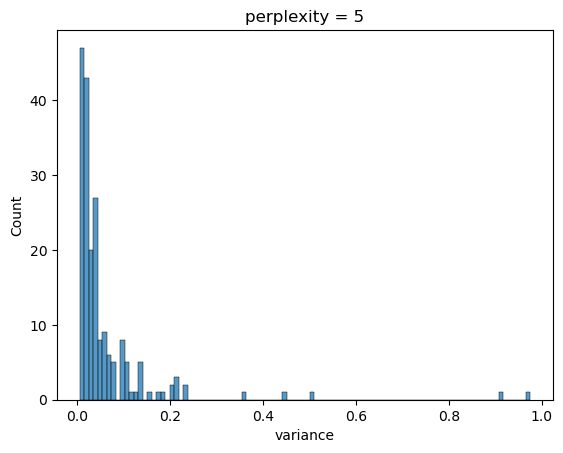

In [27]:
sns.histplot(hf["5"])
plt.title("perplexity = 5")
plt.xlabel("variance")

Text(0.5, 0, 'variance')

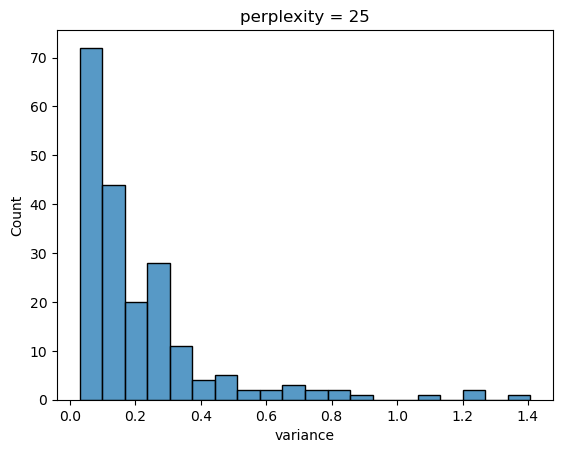

In [24]:
sns.histplot(hf["25"])
plt.title("perplexity = 25")
plt.xlabel("variance")

Text(0.5, 0, 'variance')

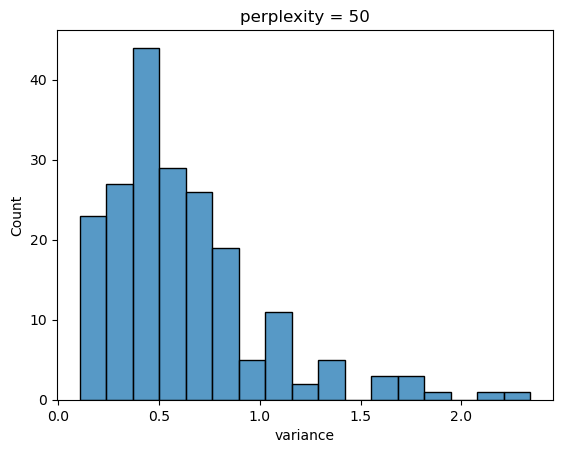

In [25]:
sns.histplot(hf["50"])
plt.title("perplexity = 50")
plt.xlabel("variance")

Text(0.5, 0, 'variance')

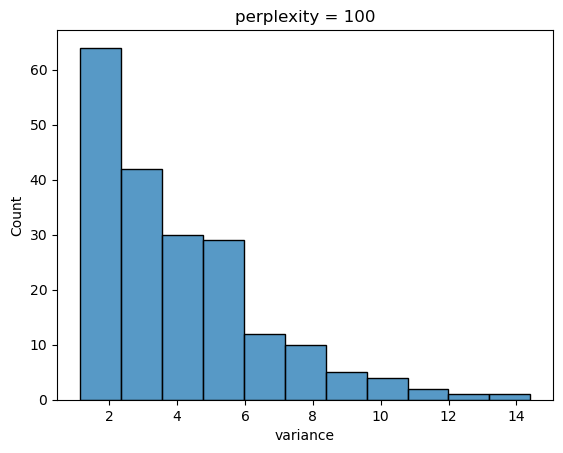

In [26]:
sns.histplot(hf["100"])
plt.title("perplexity = 100")
plt.xlabel("variance")